In [3]:
import random
import math
import torch
import sys
import copy
import pickle
import torch.nn as nn
import scipy as sp
import scipy.stats as sps
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# ======================================
# Prepare Data
def make_batch(data, batch_size, window_size, shuffle=True):
    window_list = []
    for i in range(len(data) - window_size - 1):
        window = data[i: i + window_size]
        window_list.append(window)

    if shuffle:
        random.shuffle(window_list)

    n_batch = math.ceil(len(window_list) / batch_size)
    batch_list = []
    for i in range(n_batch):
        batch = window_list[i*batch_size: (i+1)*batch_size]
        batch_list.append(batch)
    batch_list = np.array(batch_list)

    return batch_list

data = pd.read_csv("./all_metric_sort_err.csv", sep=',', index_col=False)

In [5]:
anormal_CPU = pd.read_csv("./CPU_metric_sort.csv", sep=',', index_col=False)

In [6]:
anormal_CPU.keys()

Index(['node_boot_time_seconds', 'node_boot_time_seconds.1',
       'node_context_switches_total', 'node_context_switches_total.1',
       'node_cpu_frequency_max_hertz', 'node_cpu_frequency_max_hertz.1',
       'node_cpu_frequency_max_hertz.2', 'node_cpu_frequency_max_hertz.3',
       'node_cpu_frequency_max_hertz.4', 'node_cpu_frequency_max_hertz.5',
       ...
       'node_softnet_processed_total.16', 'node_softnet_processed_total.17',
       'node_softnet_processed_total.18', 'node_softnet_processed_total.19',
       'node_softnet_processed_total.20', 'node_softnet_processed_total.21',
       'node_softnet_processed_total.22', 'node_softnet_processed_total.23',
       'node_softnet_processed_total.24', 'node_softnet_processed_total.25'],
      dtype='object', length=1657)

In [7]:
data.head()

,node_boot_time_seconds,node_boot_time_seconds.1,node_context_switches_total,node_context_switches_total.1,node_cpu_frequency_max_hertz,node_cpu_frequency_max_hertz.1,node_cpu_frequency_max_hertz.2,node_cpu_frequency_max_hertz.3,node_cpu_frequency_max_hertz.4,node_cpu_frequency_max_hertz.5,...,node_softnet_processed_total.16,node_softnet_processed_total.17,node_softnet_processed_total.18,node_softnet_processed_total.19,node_softnet_processed_total.20,node_softnet_processed_total.21,node_softnet_processed_total.22,node_softnet_processed_total.23,node_softnet_processed_total.24,node_softnet_processed_total.25
0,1596767999,1596781334,5758230699,37974415433,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544702,23436296,24701006,46671236,47947309,44975004,46843927,45760864,63930543,44422656
1,1596767999,1596781334,5758245446,37974538311,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544717,23436551,24701007,46671276,47947361,44975035,46844112,45760923,63930635,44422703
2,1596767999,1596781334,5758264904,37974658948,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544782,23436557,24701036,46671443,47947485,44975165,46844366,45761027,63930885,44422959
3,1596767999,1596781334,5758284370,37974786059,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544782,23436557,24701036,46671450,47947498,44975181,46844387,45761054,63930967,44422966
4,1596767999,1596781334,5758305482,37974907235,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544858,23436564,24701043,46671924,47947955,44975292,46844543,45761183,63931182,44423190


In [8]:
#data = data[data.fault == 0]

In [9]:
headers = [h for h in data.keys() if not h.startswith('container_') and not h.startswith("go_") and h in anormal_CPU.keys()]

In [10]:
data =data[headers]

In [11]:
data.head()

,node_boot_time_seconds,node_boot_time_seconds.1,node_context_switches_total,node_context_switches_total.1,node_cpu_frequency_max_hertz,node_cpu_frequency_max_hertz.1,node_cpu_frequency_max_hertz.2,node_cpu_frequency_max_hertz.3,node_cpu_frequency_max_hertz.4,node_cpu_frequency_max_hertz.5,...,node_softnet_processed_total.16,node_softnet_processed_total.17,node_softnet_processed_total.18,node_softnet_processed_total.19,node_softnet_processed_total.20,node_softnet_processed_total.21,node_softnet_processed_total.22,node_softnet_processed_total.23,node_softnet_processed_total.24,node_softnet_processed_total.25
0,1596767999,1596781334,5758230699,37974415433,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544702,23436296,24701006,46671236,47947309,44975004,46843927,45760864,63930543,44422656
1,1596767999,1596781334,5758245446,37974538311,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544717,23436551,24701007,46671276,47947361,44975035,46844112,45760923,63930635,44422703
2,1596767999,1596781334,5758264904,37974658948,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544782,23436557,24701036,46671443,47947485,44975165,46844366,45761027,63930885,44422959
3,1596767999,1596781334,5758284370,37974786059,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544782,23436557,24701036,46671450,47947498,44975181,46844387,45761054,63930967,44422966
4,1596767999,1596781334,5758305482,37974907235,2100000000,2100000000,2100000000,2100000000,2100000000,2100000000,...,25544858,23436564,24701043,46671924,47947955,44975292,46844543,45761183,63931182,44423190


In [12]:
data.shape[1]

1657

In [13]:
data = data.to_numpy()
#scaler = MinMaxScaler(feature_range=(0,10))
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [14]:
print(data.shape)
print('###############ddddd')

(275, 1657)
###############ddddd


In [15]:
# ======================================
# Modeling
class SequenceModel(nn.Module):
    def __init__(self, input_size=1796, output_dim=1796, hidden_size=256, num_layers=1):
        super(SequenceModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.scaler_bias = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.scaler = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = (x + self.scaler_bias) * self.scaler
        zs, hidden = self.lstm(x)
        z = zs[:, -1]
        v = self.linear(zs)
        return v, z

In [16]:
# ======================================
# Training
window_size = 10
batch_size = 192
hidden_size = 128
use_cuda = True
n_feature = data.shape[1]

model = SequenceModel(input_size=n_feature,
                      output_dim=n_feature,
                      hidden_size=hidden_size,
                      num_layers=1)

if use_cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

n_epoch = 40000
ema_loss = None
alpha = 0.1
verbose_interval = 50

In [17]:
for epoch_i in range(n_epoch):

    batch_list = make_batch(data, batch_size, window_size+1)
    for batch_i, batch in enumerate(batch_list):
        optimizer.zero_grad()

        batch = np.array(batch)
        batch_input = batch[:, :-1, :]
        batch_output = batch[:, 1:, :]

        batch_input = torch.tensor(batch_input, dtype=torch.float32)
        batch_output = torch.tensor(batch_output, dtype=torch.float32)

        if use_cuda:
            batch_input = batch_input.cuda()
            batch_output = batch_output.cuda()
        
        v, _ = model(batch_input)

        loss = loss_fn(v, batch_output)

        loss.backward()
        optimizer.step()

        if ema_loss is None:
            ema_loss = loss.item()
        ema_loss = loss.item() * alpha + (1.-alpha) * ema_loss

    if epoch_i % verbose_interval == 0:
        print(f"{epoch_i}th epoch, loss: {ema_loss}")

0th epoch, loss: 0.3765429824590683
50th epoch, loss: 0.08016429606807536
100th epoch, loss: 0.06571353587763182
150th epoch, loss: 0.057492697332294354
200th epoch, loss: 0.05256369954749639
250th epoch, loss: 0.049223216604152104
300th epoch, loss: 0.04541369904065704
350th epoch, loss: 0.042126792840800995
400th epoch, loss: 0.03918859368938441
450th epoch, loss: 0.036810803376122
500th epoch, loss: 0.034506207957902
550th epoch, loss: 0.032549955376333276
600th epoch, loss: 0.0310741388419924
650th epoch, loss: 0.029481640723205887
700th epoch, loss: 0.02858520326327207
750th epoch, loss: 0.02725667889291715
800th epoch, loss: 0.026685929587726438
850th epoch, loss: 0.025670279354954258
900th epoch, loss: 0.024764340834406262
950th epoch, loss: 0.024151997369117134
1000th epoch, loss: 0.02396259730679466
1050th epoch, loss: 0.02308012976220001
1100th epoch, loss: 0.022357503904474475
1150th epoch, loss: 0.02245000512360899
1200th epoch, loss: 0.021490210376722205
1250th epoch, loss

In [26]:
# ======================================
# Inference
model.eval()
model.cpu()


# Prepare train data distribution
Z = []
reconstruction_error = []

batch_list = make_batch(data, batch_size, window_size, False)
for batch_i, batch in enumerate(batch_list):
    batch = np.array(batch)
    batch_input = batch

    batch_input = torch.tensor(batch_input, dtype=torch.float32)
    batch_output = torch.tensor(batch_output, dtype=torch.float32)

    v, z = model(batch_input)

    Z.extend(z.tolist())
    reconstruction_error.extend(torch.sum(torch.abs(v-batch_input), dim=[1,2]).detach().tolist())

Z = np.array(Z)
reconstruction_error = np.array(reconstruction_error)

/home/ubuntu/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [27]:
# Samples for quering

sample_pos = data[:]
sample_neg = data[46:55] 

sample_pos = np.array(sample_pos)  # sequence_length x featbure size
sample_pos = torch.tensor(sample_pos, dtype=torch.float32)  # sequence_length x feature size
sample_pos = sample_pos.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_pos, z_prime_pos = model(sample_pos)


# neg
#sample_neg = np.array(sample_neg)  # sequence_length x feature size
#sample_neg = torch.tensor(sample_neg, dtype=torch.float32)  # sequence_length x feature size
#sample_neg = sample_neg.unsqueeze(0)  # 1 x sequence_length x feature size
#prediction_neg, z_prime_neg = model(sample_neg)

z_prime_pos = z_prime_pos.detach().numpy()
#z_prime_neg = z_prime_neg.detach().numpy()

reconstruction_error_pos = torch.sum(torch.abs(prediction_pos[:, -1:,:] - sample_pos[:, :-1, :]), dim=[1,2]).detach().tolist()
#reconstruction_error_neg = torch.sum(torch.abs(prediction_neg[:, -1:,:] - sample_neg[:, :-1, :]), dim=[1,2]).detach().tolist()

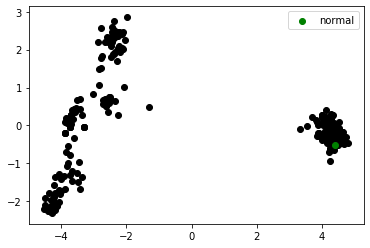

In [28]:
# ======================================
# Visualize latent space
pca = PCA(n_components=2)
pca.fit(Z)

Z_2d = pca.transform(Z)
z_prime_pos_2d = pca.transform(z_prime_pos)
#z_prime_neg_2d = pca.transform(z_prime_neg)

plt.scatter(Z_2d[:, 0], Z_2d[:, 1], color='k')
plt.scatter(z_prime_pos_2d[:, 0],z_prime_pos_2d[:, 1] , color='g', label='normal')
#plt.scatter(z_prime_neg_2d[:, 0],z_prime_neg_2d[:, 1] , color='r', label='abnormal')
plt.legend()
plt.show()
print(reconstruction_error)

In [29]:
##pdf value store

rce_std = np.std(reconstruction_error)
rce_mean = np.mean(reconstruction_error)
print(rce_std)
print(rce_mean)

sys.stdout = open("./ckpt/pdf.txt",'w')
print(rce_std, rce_mean)

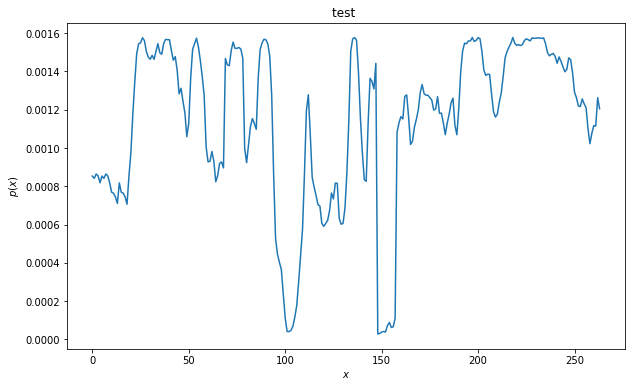

In [30]:
rv = sps.norm(loc=rce_mean, scale=rce_std)
pdf = rv.pdf(reconstruction_error)
plt.figure(figsize=(10, 6)) 
plt.plot(range(len(pdf)), pdf)

# plt.plot(reconstruction_error, pdf)
plt.title("test ")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.show()

(array([13., 18., 13., 31., 22., 17., 15., 12., 12.,  8., 20., 16.,  8.,
         3.,  6.,  4.,  0.,  7.,  7.,  8.,  3.,  2.,  1.,  1.,  1.,  1.,
         3.,  4.,  2.,  6.]),
 array([ 425.2729187 ,  459.85550842,  494.43809814,  529.02068787,
         563.60327759,  598.18586731,  632.76845703,  667.35104675,
         701.93363647,  736.5162262 ,  771.09881592,  805.68140564,
         840.26399536,  874.84658508,  909.4291748 ,  944.01176453,
         978.59435425, 1013.17694397, 1047.75953369, 1082.34212341,
        1116.92471313, 1151.50730286, 1186.08989258, 1220.6724823 ,
        1255.25507202, 1289.83766174, 1324.42025146, 1359.00284119,
        1393.58543091, 1428.16802063, 1462.75061035]),
 <a list of 30 Patch objects>)

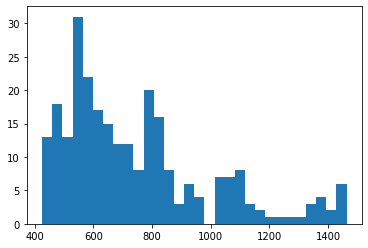

In [31]:
plt.hist(reconstruction_error,bins=30)

In [32]:
# Model Store
torch.save(model.state_dict(), "ckpt/model.ckpt")

with open("./ckpt/Z.pickle", "wb") as f:
    pickle.dump(Z, f)

In [33]:
with open("./ckpt/scaler.pickle", "wb") as f:
    pickle.dump(scaler, f)